<a href="https://colab.research.google.com/github/rudraxx/pytorch/blob/main/04_fashion_mnist_mlp_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import os
import torchvision
from torchvision import datasets, transforms
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.transforms.functional import pil_to_tensor
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import torch.optim as optim


print(torch.__version__)

2.3.1+cu121


In [2]:
'''
Get Fashion Dataset
Create Dataloaders
Create class for ML model - MLP
Run training
Plot training results
'''




'\nGet Fashion Dataset\nCreate Dataloaders\nCreate class for ML model - MLP\nRun training\nPlot training results\n'

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


In [4]:
# Torch tests
x = torch.randn([3,5],dtype=torch.float32)
print(x)


tensor([[ 1.0153, -1.3467, -0.6573,  2.0047,  0.6561],
        [-0.1493, -1.1411,  0.3702,  0.3496,  0.8613],
        [ 1.4230,  0.9259, -0.1260,  1.2167, -0.6560]])


In [5]:
# Get Dataset by applying the transform during loading data.
# Note: without this, the data gets loaded as a PIL image and that has to be manually converted into tensor using torchvision.transforms.
# Note: The transform is applied only to the data, not the label.

transform = transforms.Compose(transforms=
                                [transforms.ToTensor()])

fashion_mnist_train = datasets.FashionMNIST('root',
                                            train=True,download=True)#,
                                            #transform=transform)
ds_test  = datasets.FashionMNIST('root',
                                 train=False,download=True)#,
                                 #transform=transform)

print(f"Train dataset size: {len(fashion_mnist_train)}")
print(f"Test dataset size: {len(ds_test)}")

print("Example of ds_test with no Transform  applied during dataset creation\n ", ds_test[0])

#Show example of applying transform after loading:
# pil_img = ds_test[0][0]
# print("Example of ds_test with Transform applied after dataset creation\n", transform(pil_img))


100%|██████████| 26421880/26421880 [00:11<00:00, 2312535.58it/s]


Extracting root/FashionMNIST/raw/train-images-idx3-ubyte.gz to root/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 208207.00it/s]


Extracting root/FashionMNIST/raw/train-labels-idx1-ubyte.gz to root/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3461276.29it/s]


Extracting root/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to root/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5785711.95it/s]

Extracting root/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to root/FashionMNIST/raw

Train dataset size: 60000
Test dataset size: 10000
Example of ds_test with no Transform  applied during dataset creation
  (<PIL.Image.Image image mode=L size=28x28 at 0x78A568F33E20>, 9)


In [6]:
# Apply the transform while extracting the data.
transform = transforms.Compose(transforms=
                                [transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.2860], std=[0.3523])])

fashion_mnist_train = datasets.FashionMNIST('root',
                                            train=True,download=True,
                                            transform=transform)
ds_test  = datasets.FashionMNIST('root',
                                 train=False,download=True,
                                 transform=transform)

print(f"Train dataset size: {len(fashion_mnist_train)}")
print(f"Test dataset size: {len(ds_test)}")



Train dataset size: 60000
Test dataset size: 10000


In [7]:
# Create the splits
ds_train, ds_val = torch.utils.data.random_split(fashion_mnist_train, [0.8, 0.2])

print(f"Final Train dataset size: {len(ds_train)}")
print(f"Final Val dataset size  : {len(ds_val)}")
print(f"Final Test dataset size : {len(ds_test)}")



Final Train dataset size: 48000
Final Val dataset size  : 12000
Final Test dataset size : 10000


In [8]:
#Get the classes and create the dictionary to link index to class names
dict_classes = {idx:name for idx,name in enumerate(ds_train.dataset.classes)}
print(dict_classes)

NUM_CLASSES = len(dict_classes)
print(f"NUM_CLASSES = {NUM_CLASSES}")


{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
NUM_CLASSES = 10


In [9]:
# Get the size of the images
img, label = ds_train[0]
print("Image shape is: ", img.shape)
IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH = img.shape

print(f"IMG_HEIGHT={IMG_HEIGHT}, IMG_WIDTH={IMG_WIDTH}, IMG_CHANNELS={IMG_CHANNELS}")

Image shape is:  torch.Size([1, 28, 28])
IMG_HEIGHT=28, IMG_WIDTH=28, IMG_CHANNELS=1


In [10]:
#Make the dataloaders:
BATCH_SIZE=64
dl_train = DataLoader(ds_train,batch_size=BATCH_SIZE, shuffle=True)
dl_val   = DataLoader(ds_val,batch_size=BATCH_SIZE, shuffle=True)
dl_test  = DataLoader(ds_test,batch_size=BATCH_SIZE, shuffle=True)

print(f"Batch size = {BATCH_SIZE}")
print("Number of batches in ds_train = ", len(ds_train))
print(f"Number of batches in dl_train based on batch size={BATCH_SIZE} is: {len(dl_train)} ")


Batch size = 64
Number of batches in ds_train =  48000
Number of batches in dl_train based on batch size=64 is: 750 


In [11]:
# The Standardization was applied in the transforms. If that is correct, then running this calculation again will show a mean of ~0 and std of 1

# Need to normalize the data.
# transforms.ToTensor() scales from 0-1 automatically - but only after the dataloader is used.
# If checking the dataset directly, the alues will still be in the range 0,255
# It also doesnt standardize the data.
#

#Calculate the mean and std of the dataset from the dataloader
def calc_mean_std_of_dataset(dl):

  # in this case, dataloader returns this shape: # B X C X H X W
  tmp_data, labels = next(iter(dl))
  # print(tmp_data)
  num_channels = tmp_data.shape[1] # this is the number of channels
  print(f"num_channels = {num_channels}")

  mean = torch.zeros(num_channels, dtype=torch.float32)
  var = torch.zeros(num_channels, dtype=torch.float32)
  # std=0.
  num_iters = 0.

  for images, _ in iter(dl):

    if num_iters % 500 ==0:
      print( f"running through batch: {num_iters}")

    # Make channels as the first dimension
    images = images.permute(1,0,2,3)    # Now this is of size: C X B X H X W

    #Get a view of the data so that the reuslt is C X B*W*H
    data = images.view(images.size(0), -1)
    # print(data.shape)
    mean += data.mean(1) # C X 1

    #For std, keep track of the variances across each batch and then average those values to eventually get the std.
    var  += data.std(1)**2

    #Increment the iter counter
    num_iters += 1

  #Once you have looped through all the data,
  # calculate the average of the mean and std
  if num_iters>0:
    mean = mean.numpy() / num_iters
    std  = (var.numpy() / num_iters) **0.5

  # print("Total Images in this dataset: ", num_images)

  #Note: mean = d2.mean(2).mean(0), and std  = d2.std(2).std(0) is not correct.
  # mean is fine, but std(2).std(0) is not the same as std(full_dataset)


  return mean, std

#Test it out
mean, std = calc_mean_std_of_dataset(dl_train)

print(f"For dl_train dataloader, Calculated mean={mean}, std={std}")


num_channels = 1
running through batch: 0.0
running through batch: 500.0
For dl_train dataloader, Calculated mean=[0.00049078], std=[1.0013186]


In [12]:

# data = torch.rand([2,1,3,3])
# print(f"Orig data={data}")

# d2 = data.view(data.size(0), data.size(1), -1)
# print("Reshaped data", d2.shape, d2)

# mean = d2.mean(2).mean(0)
# std  = d2.std(2).std(0)

# print("Default method stats: ", mean, std)

# # Do it with the other method
# num_channels = data.shape[1] # this is the number of channels

# mean = torch.zeros(num_channels, dtype=torch.float32)
# std = torch.zeros(num_channels, dtype=torch.float32)
# # print(mean, std)
# d3 = data.permute(1,0,2, 3)

# for ch in range(num_channels):
#   new_data = d3[ch,:].view(1,-1) # What is the final dimension you want for this array?
#   print(f"new_data={new_data}")
#   # print("mean = ", torch.mean(new_data))
#   # print("std = ", torch.std(new_data))
#   mean[ch] += torch.mean(new_data)
#   std[ch] += torch.std(new_data)

# # d3 = d3[0,:].view(1,-1)
# # print(d3.shape, d3)
# # mean[num_channels] += torch.mean(data)
# # std[num_channels] += torch.std(data)

# print("My  method stats: ", mean, std)

Batch of images shape: torch.Size([64, 1, 28, 28])
Shape of grid torch.Size([3, 368, 203])


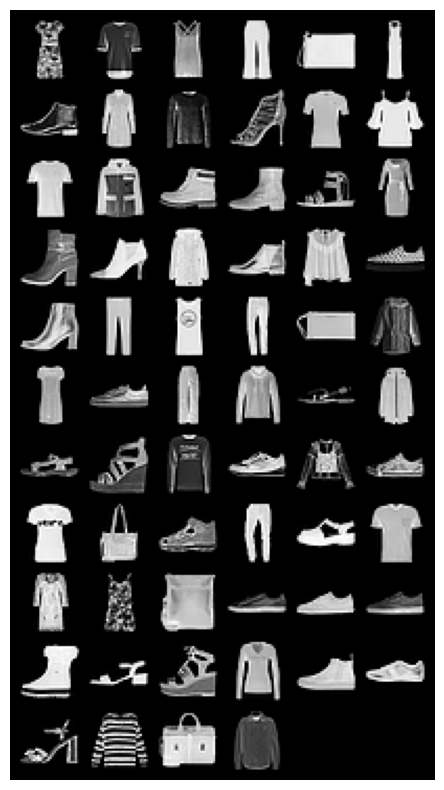

In [13]:
# Show some of the images

# Get a batch of images
images, labels = next(iter(dl_train))

print("Batch of images shape:", images.shape)
#Create the grid
grid_img = make_grid(images, nrow=6,
                     normalize=True, scale_each=True,
                     padding=5)
print("Shape of grid", grid_img.shape)

#Display
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1,2,0).cpu().numpy())
plt.axis('off')
plt.show()


In [14]:
# Create the model
class MLP_FashionMNIST(nn.Module):
  def __init__(self, n_input, n_hidden_layers, n_hidden_nodes_per_layer, n_outputs):
    super().__init__()

    self.n_input = n_input
    self.n_hidden_layers = n_hidden_layers
    self.n_hidden_nodes_per_layer = n_hidden_nodes_per_layer
    self.n_outputs = n_outputs

    # Initialize the layer list
    layers= []

    #Create input layer
    layers.append(nn.Flatten())
    layers.append(nn.Linear(n_input, n_hidden_nodes_per_layer))
    layers.append(nn.ReLU())

    for i in range(0,n_hidden_layers):
      layers.append(nn.Linear(n_hidden_nodes_per_layer, n_hidden_nodes_per_layer))
      layers.append(nn.ReLU())

    # Add the final layer
    layers.append(nn.Linear(n_hidden_nodes_per_layer, n_outputs))

    #Need logits for multiclass classification.
    #The softmax is directly applied in the cross entropy loss

    self.model = nn.Sequential(*layers)

  def forward(self, x):

    return self.model(x)




In [15]:
# Instantiate the model and see the structure
model_mlp = MLP_FashionMNIST(n_input = IMG_HEIGHT*IMG_WIDTH,
                         n_outputs=NUM_CLASSES,
                         n_hidden_layers=1,
                         n_hidden_nodes_per_layer=128)

print("The MLP model is: ", model_mlp)

The MLP model is:  MLP_FashionMNIST(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [16]:
# Test the model to see if everything is working as expected
x = torch.randn([BATCH_SIZE,1,IMG_HEIGHT,IMG_WIDTH], dtype=torch.float32)
out = model_mlp(x)
print(f"Output shape: {out.shape}")


Output shape: torch.Size([64, 10])


In [17]:
class CNN_FashionMNIST(nn.Module):
  def __init__(self, in_shape, n_layers, n_outputs):
    super(CNN_FashionMNIST,self).__init__()

    #Set up the layers
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=1,
                  out_channels=16,
                  kernel_size=3,
                  stride=1,
                  padding=2),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(16,32,3,1,2),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )

    self.flatten = nn.Flatten()

    #Fully connected layer with 10 outputs
    self.out = nn.Linear(32*8*8, 10)

  def forward(self, x):
    x=self.conv1(x)
    # print(f"Shape after first layer: {x.shape}")
    x=self.conv2(x)
    # print(f"Shape after second layer: {x.shape}")

    x=self.flatten(x)
    # print(f"Shape after flatten layer: {x.shape}")

    output = self.out(x)
    # print(f"Shape of output layer: {x.shape}")

    return output


In [18]:
#CNN Model
model = CNN_FashionMNIST(28*28, 2, 10)
print("The CNN model is: ", model)

#Test
x = torch.randn([10,1,28,28], dtype=torch.float32)

out = model(x)

print(out.shape)



The CNN model is:  CNN_FashionMNIST(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (out): Linear(in_features=2048, out_features=10, bias=True)
)
torch.Size([10, 10])


In [19]:
# Create the training loop

#Move the content to the device
model = model.to(device)

lr = 1e-3
epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []
val_losses = []

for epoch in range(epochs):
  #Set in train mode
  model.train()
  running_loss = 0.0
  for inputs, labels in dl_train:

    #Zero the gradients.
    optimizer.zero_grad()

    #Forward pass
    out = model(inputs.to(device))

    # Get the loss
    loss = criterion(out, labels.to(device))

    #compute the gradients
    loss.backward()

    #Apply the gradients
    optimizer.step()

    #Add the running loss
    running_loss += loss.item()  # .item() will give the value, not the tensor.

  # Save training loss
  current_training_loss = running_loss/len(dl_train)
  train_losses.append(current_training_loss)

  # Get the validation loss
  #Set in validation mode
  model.eval()
  running_val_loss = 0.0

  with torch.no_grad():
    for inputs, labels in dl_val:

      #Forward pass
      out = model(inputs.to(device))

      # Get the loss
      loss = criterion(out, labels.to(device))

      #Add the running loss
      running_val_loss += loss.item()  # .item() will give the value, not the tensor.

  # Save validation loss
  current_val_loss = running_val_loss/len(dl_val)
  val_losses.append(current_val_loss)
  print(f"Epoch {epoch+1}/ {epochs}, Train loss: {current_training_loss}, Val Loss:  {current_val_loss}")






Epoch 1/ 10, Train loss: 0.486264203508695, Val Loss:  0.3465024924024622
Epoch 2/ 10, Train loss: 0.32398674033085506, Val Loss:  0.3030189873769562
Epoch 3/ 10, Train loss: 0.2834283271829287, Val Loss:  0.2803046224599189
Epoch 4/ 10, Train loss: 0.25787017214794955, Val Loss:  0.277380450212575
Epoch 5/ 10, Train loss: 0.23789681887626649, Val Loss:  0.2574348946280302
Epoch 6/ 10, Train loss: 0.22366856953998407, Val Loss:  0.26564181663412995
Epoch 7/ 10, Train loss: 0.21014649192492166, Val Loss:  0.24997733390711724
Epoch 8/ 10, Train loss: 0.1985318219314019, Val Loss:  0.2470097829924619
Epoch 9/ 10, Train loss: 0.187544250741601, Val Loss:  0.2521057720197008
Epoch 10/ 10, Train loss: 0.17567264338831107, Val Loss:  0.25605906304368314


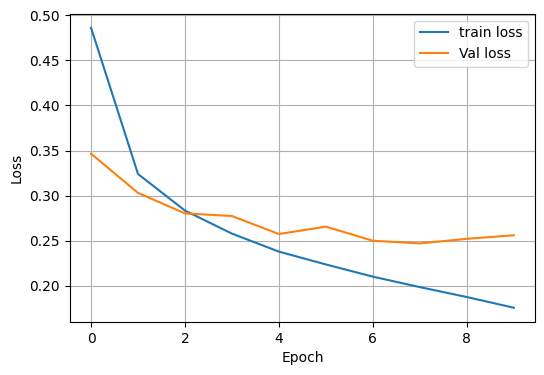

In [20]:
import numpy as np

plt.figure(figsize=(6,4))
plt.plot(np.arange(0,epochs), train_losses, label="train loss")
plt.plot(np.arange(0,epochs), val_losses, label="Val loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid('on')

In [22]:
# Get the test loss
#Set in validation mode
model.eval()
running_test_loss = 0.0

with torch.no_grad():
  for inputs, labels in dl_test:

    #Forward pass
    out = model(inputs.to(device))

    # Get the loss
    loss = criterion(out, labels.to(device))

    #Add the running loss
    running_test_loss += loss.item()  # .item() will give the value, not the tensor.

# Save validation loss
current_test_loss = running_test_loss/len(dl_test)
val_losses.append(current_test_loss)
print(f"Test loss: {current_test_loss}")




Test loss: 0.2786414851998068
